In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast, Resizing, Rescaling
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, Layer, Input, BatchNormalization, Dropout
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Recall, Precision, AUC

In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised = True, split = ['train'], shuffle_files = True)

In [4]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [5]:
def splits(data, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  size = len(data)
  train_dataset = data.take(int(TRAIN_RATIO*size))

  val_test_dataset = data.skip(int(TRAIN_RATIO*size))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*size))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*size))

  return train_dataset, val_dataset, test_dataset

In [6]:
print(list(dataset[0].take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]


In [7]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [8]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

**DATA VISUALIZATION**

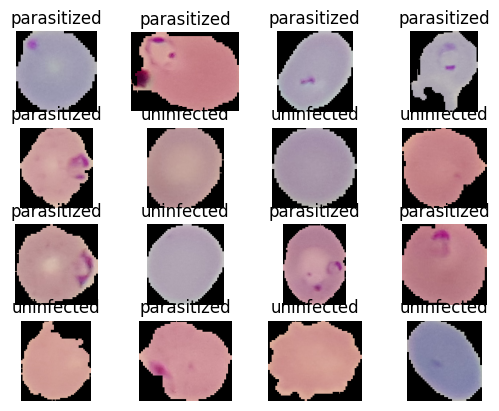

In [9]:
for i, (img, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.imshow(img)
  plt.axis('off')

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)


original_image, label = next(iter(train_dataset))


augmented_image = tf.image.adjust_saturation(original_image, saturation_factor = 0.3)


visualize(original_image, augmented_image)

**DATA PREPROCESSING**

**DATA AUGMENTATION**

In [10]:
IMG_SIZE = 224

def resize_rescale(image, label):
  return tf.image.resize(image, size = (IMG_SIZE, IMG_SIZE))/255.0, label

In [ ]:
def augment(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)

  return image, label

In [ ]:
# tf.keras.layer resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
       Resizing(IMG_SIZE, IMG_SIZE),
       Rescaling(1./255),
])

In [ ]:
# tf.keras.layer augment
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),

])

@tf.function
def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

In [11]:
BATCH_SIZE = 32

In [12]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [13]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(resize_rescale)
    .batch(BATCH_SIZE, num_parallel_calls = tf.data.AUTOTUNE)
)

In [14]:
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)

In [ ]:
DROPOUT_RATE = 0.2

**SEQUENTIAL API**

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(filters = 6, strides=1, kernel_size = 5, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = 16, strides=1, kernel_size = 5, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),

    Flatten(),

    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE ),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid'),
])


**FUNCTIONAL API**

In [ ]:

func_input = Input(shape = (IMG_SIZE, IMG_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides= 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D (pool_size = 2, strides= 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),



])
feature_extractor_seq_model.summary()

In [ ]:
func_input = Input(shape = (IMG_SIZE, IMG_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

**Model Subclassing**

In [15]:

class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [16]:
func_input = Input(shape = (IMG_SIZE, IMG_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (FeatureE  (None, 54, 54, 16)       1488      
 xtractor)                                                       
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 100)               4665700   
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                

In [17]:

class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_6 (Batc  multiple                 400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_7 (Batc  multiple                 

**CUSTOM LAYERS**

In [18]:
class NeuralLearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralLearnDense, self).__init__()
    self.ouput_units = output_units
    self.activation = activation

  def build(self, input_feature_shape):
    self.weights = self.add_weight(shape = (input_feature_shape[-1], self.ouput_units), initializer="random_normal", trainable = True)
    self.biases = self.add_weight(shape = (self.output_units,), initializer="random_normal", trainable=True)

  def call(self, input_features):
    pre_ouptut = tf.matmul(input_features, self.weights) + self.biases

    if(self.activation == "relu")
      return tf.relu(pre_ouptut)
    elif(self.activation == "sigmoid")
      return tf.sigmoid(pre_ouptut)

    return pre_ouptut


In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(filters = 6, strides=1, kernel_size = 5, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),

    Conv2D(filters = 16, strides=1, kernel_size = 5, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),

    Flatten(),

    NeuralLearnDense(100, activation = 'relu'),
    BatchNormalization(),

    NeuralLearnDense(10, activation='relu'),
    BatchNormalization(),

    NeuralLearnDense(1, activation='sigmoid'),
])

In [18]:
csv_callback = CSVLogger(
    'log.csv', separator=',', append=False
)

In [19]:
metrics = [TruePositives(name='tp'), TrueNegatives(name='tn'), FalsePositives(name='fp'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [20]:
lenet_model_func.compile(optimizer = Adam(learning_rate = 0.01),
                        loss = BinaryCrossentropy(),
                        metrics = metrics)

In [21]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))


**Early Stopping**

In [24]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

**Learning Rate Scheduler**

In [25]:
def scheduler(epoch, lr):

  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()

  # with train_writer.as_default():
  #   tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

**Model CheckPointing**

In [27]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_precision', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
)

**Reduce Learning Rate on Plateau**

In [28]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)

In [22]:
history = lenet_model_func.fit(train_dataset, validation_data = val_dataset, epochs =1, verbose = 1, callbacks=[csv_callback])

689/689 [==============================] - 916s 1s/step - loss: 0.6141 - tp: 7322.0000 - tn: 7329.0000 - fp: 3694.0000 - fn: 3701.0000 - accuracy: 0.6646 - precision: 0.6647 - recall: 0.6642 - auc: 0.7237 - val_loss: 1.5013 - val_tp: 0.0000e+00 - val_tn: 1359.0000 - val_fp: 1.0000 - val_fn: 1395.0000 - val_accuracy: 0.4933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5913


**VISUALIZATION**

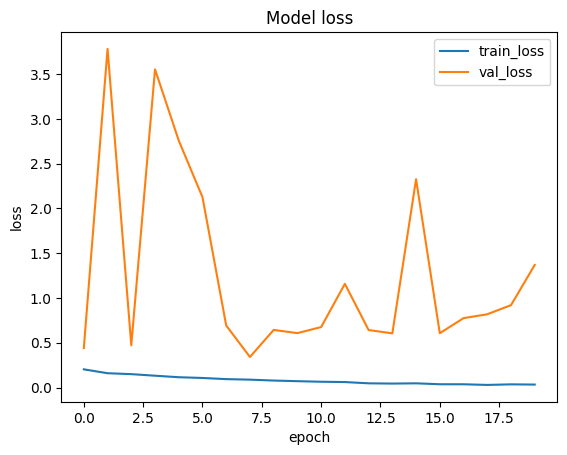

In [128]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()


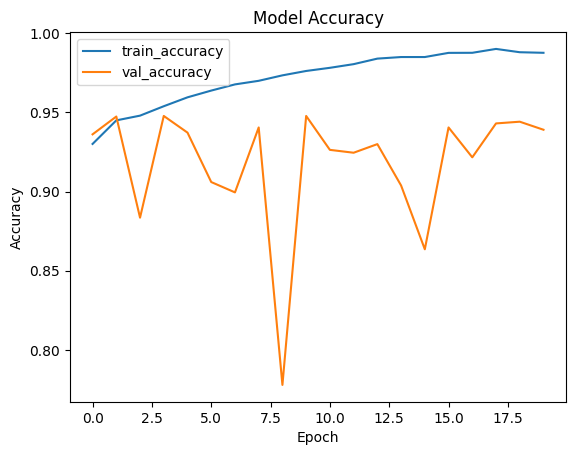

In [129]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [146]:
test_dataset = test_dataset.batch(1)

In [147]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [148]:
lenet_model_func.evaluate(test_dataset)

2757/2757 [==============================] - 27s 5ms/step - loss: 1.0810 - tp: 1322.0000 - tn: 1245.0000 - fp: 150.0000 - fn: 40.0000 - accuracy: 0.9311 - precision: 0.8981 - recall: 0.9706 - auc: 0.9625


[1.0809696912765503,
 1322.0,
 1245.0,
 150.0,
 40.0,
 0.9310845136642456,
 0.898097813129425,
 0.9706314206123352,
 0.9625012278556824]

In [149]:
labels = []
input = []

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  input.append(x)

In [150]:
label = np.array([i[0] for i in labels])
print(label)

[0 1 0 ... 1 0 1]


In [151]:
np.array(input).shape

(2757, 1, 224, 224, 3)

In [152]:
pred = lenet_model_func.predict(np.array(input)[:,0,...])

87/87 [==============================] - 2s 14ms/step


In [153]:
pred.shape

(2757, 1)

In [154]:
threshold = 0.75
cm = confusion_matrix(labels, pred>threshold)
cm

array([[1263,  130],
       [  45, 1319]])

Text(33.22222222222222, 0.5, 'Actual')

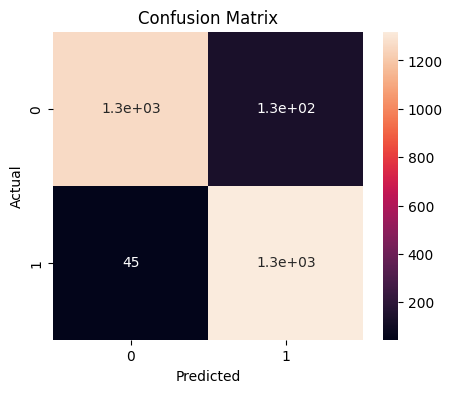

In [155]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

**ROC Plot**

In [156]:
fp, tp, thres = roc_curve(labels, pred)
print(len(fp), len(tp), len(thres))

312 312 312


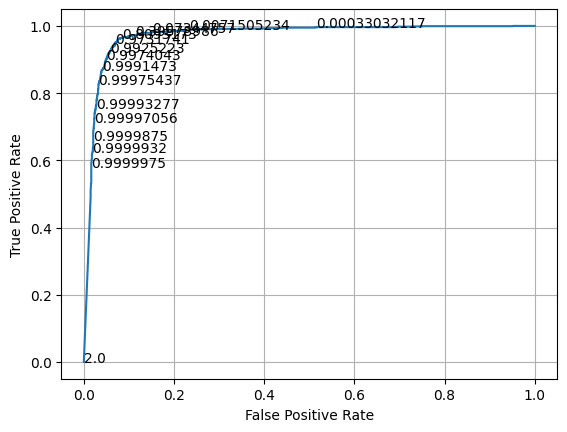

In [157]:
plt.plot(fp, tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 20

for i in range(0, len(thres), skip):
  plt.text(fp[i], tp[i], thres[i])

plt.show()

In [108]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 18ms/step


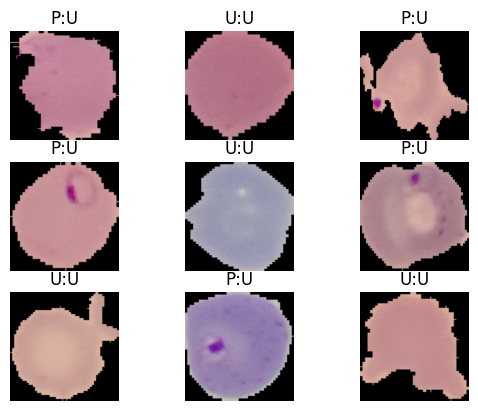

In [109]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model_func.predict(image)[0][0])))

  plt.axis('off')